In [1]:
%load_ext autoreload
%autoreload 2

In [125]:
import sys
import os
# Add parent directory to path
sys.path.append(os.path.abspath('..'))

import numpy as np
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import regularizers as reg
from GmGM import GmGM
from utilities import *
from nonparanormal_skeptic import *

from other_algs.EiGLasso import EiGLasso, EiGLasso_cov

# Change colorscheme to be colorblind friendly
from cycler import cycler
linestyle_cycler = cycler('linestyle',['-','--',':','-.'])
color_cycler = cycler('color',['k','orange','m','darkgreen'])
plt.rc('axes', prop_cycle=linestyle_cycler + color_cycler)

import timeit

# Load Data

In [4]:
def reload_data(
    shuffle: bool = False,
    divide_by_std: bool = False
) -> np.ndarray:
    # Read the data
    mitosis_genes = pd.read_csv('../data/E-MTAB-2805/Nmythosis.txt')
    G1_df = pd.read_csv(
        '../data/E-MTAB-2805/G1_singlecells_counts.txt',
        sep='\t'
    ).dropna()
    S_df = pd.read_csv(
        '../data/E-MTAB-2805/S_singlecells_counts.txt',
        sep='\t'
    ).dropna()
    G2M_df = pd.read_csv(
        '../data/E-MTAB-2805/G2M_singlecells_counts.txt',
        sep='\t'
    ).dropna()

    # Grab only relevant genes
    G1_df = G1_df[G1_df['EnsemblGeneID'].isin(mitosis_genes['EnsemblGeneID'])]
    S_df = S_df[S_df['EnsemblGeneID'].isin(mitosis_genes['EnsemblGeneID'])]
    G2M_df = G2M_df[G2M_df['EnsemblGeneID'].isin(mitosis_genes['EnsemblGeneID'])]

    # Convert to numpy
    G1_mat = np.log(G1_df.iloc[:, 4:].to_numpy()+1)
    S_mat = np.log(S_df.iloc[:, 4:].to_numpy()+1)
    G2M_mat = np.log(G2M_df.iloc[:, 4:].to_numpy()+1)

    # Get cell cycle phase labels
    G1_labels = np.zeros(G1_mat.shape[1])
    S_labels = np.ones(S_mat.shape[1])
    G2M_labels = np.ones(G2M_mat.shape[1]) * 2
    labels = np.concatenate([G1_labels, S_labels, G2M_labels])

    # TODO: Remove this
    #G1_mat /= np.std(G1_mat, axis=1, keepdims=True)
    #S_mat /= np.std(S_mat, axis=1, keepdims=True)
    #G2M_mat /= np.std(G2M_mat, axis=1, keepdims=True)

    log_counts = np.concatenate([G1_mat, S_mat, G2M_mat], axis=1).T[np.newaxis, ...]

    # Shuffle log_counts on cell axis
    if shuffle:
        perm = np.random.permutation(log_counts.shape[1])
        log_counts = log_counts[:, perm, :]
        labels = labels[perm]

    if divide_by_std:
        # Divide first G1_mat.shape[1] elements by their standard deviation
        log_counts[:, :G1_mat.shape[1], :] /= np.std(
            log_counts[:, :G1_mat.shape[1], :],
            axis=1,
            keepdims=True
        )

        # Divide next S_mat.shape[1] elements by their standard deviation
        log_counts[:, G1_mat.shape[1]:G1_mat.shape[1]+S_mat.shape[1], :] /= np.std(
            log_counts[:, G1_mat.shape[1]:G1_mat.shape[1]+S_mat.shape[1], :],
            axis=1,
            keepdims=True
        )

        # Divide next G2M_mat.shape[1] elements by their standard deviation
        log_counts[:, G1_mat.shape[1]+S_mat.shape[1]:, :] /= np.std(
            log_counts[:, G1_mat.shape[1]+S_mat.shape[1]:, :],
            axis=1,
            keepdims=True
        )

    return log_counts, labels
    
log_counts, labels = reload_data()
print(log_counts.shape)

(1, 288, 167)


In [17]:
def calculate_assortativities(
    thresholds: list[float],
    preds: dict[str, np.ndarray]
) -> np.ndarray:
    results = np.empty((3, len(thresholds)))
    for idx, threshold in enumerate(thresholds):
        if idx % (len(thresholds) // 10) == 0:
            print(f"({idx}/{thresholds.shape[0]}): threshold = {threshold}")
        # Get results

        # All ############################

        # Threshold
        preds_all = shrink_sparsities(
            preds,
            {"Cell": threshold / 288, "Gene": threshold / 288}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Weighted_Adjacency(
            preds_all["Cell"] + preds_all["Cell"].T,
            mode="undirected",
            attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[0, idx] = g.assortativity(labels)

        # Per Row #######################

        # Threshold
        preds_row = shrink_per_row(
            preds,
            {"Cell": threshold, "Gene": threshold}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Weighted_Adjacency(
            preds_row["Cell"] + preds_row["Cell"].T,
            mode="undirected",
            attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[1, idx] = g.assortativity(labels)

        # Per Row, Col-Weighted #########
        
        # Threshold
        preds_col = shrink_per_col(
            preds,
            {"Cell": threshold, "Gene": threshold}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Weighted_Adjacency(
            preds_col["Cell"] + preds_col["Cell"].T,
            mode="undirected",
            attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[2, idx] = g.assortativity(labels)
    return results

# Experiment 1: Thresholding Unmeaned (Keep Mean)

In [5]:
log_counts, labels = reload_data(
    shuffle=False,
    divide_by_std=False
)

In [18]:
# Vary threshold, calculate assortativity
thresholds = np.linspace(0, 288, 288).astype(int)
threshold_types = ["All", "Per Row", "Per Row, Col-Weighted"]
preds = GmGM(
    {"Test Dataset": log_counts},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=10_000,
    regularizer=None,
)
results = calculate_assortativities(thresholds, preds)

(0/288): threshold = 0
(28/288): threshold = 28
(56/288): threshold = 56
(84/288): threshold = 84
(112/288): threshold = 112
(140/288): threshold = 140
(168/288): threshold = 168
(196/288): threshold = 196
(224/288): threshold = 224
(252/288): threshold = 252
(280/288): threshold = 280


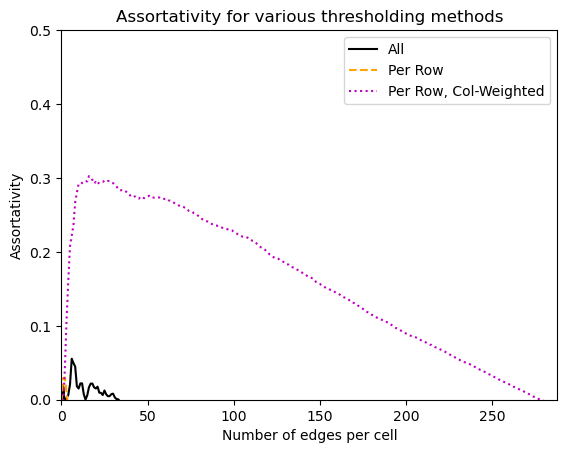

In [19]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(3):
    ax.plot(
        thresholds,
        results[i, :],
        label=f"{threshold_types[i]}"
    )
ax.set_xlabel("Number of edges per cell")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(0, 288)
ax.set_ylim(0, 0.5)

ax.set_title("Assortativity for various thresholding methods")
fig.savefig("../out_figs/mouse-assortativity-thresholding.png")
fig.savefig("../out_figs/mouse-assortativity-thresholding.svg")
pass

# Experiment 1b: Thresholding (Keep Mean) - Nonparanormal

In [29]:
# Vary threshold, calculate assortativity
thresholds = np.linspace(0, 288, 288).astype(int)
threshold_types = ["All", "Per Row", "Per Row, Col-Weighted"]
nonpara = nonparanormal_tensor_skeptic(log_counts)
nonpara = {
    "Cell": nonpara[0],
    "Gene": nonpara[1]
}
preds = GmGM(
    {"Test Dataset": log_counts},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=10_000,
    regularizer=None,
    gram_matrices=nonpara
)
results = calculate_assortativities(thresholds, preds)

(0/288): threshold = 0
(28/288): threshold = 28
(56/288): threshold = 56
(84/288): threshold = 84
(112/288): threshold = 112
(140/288): threshold = 140
(168/288): threshold = 168
(196/288): threshold = 196
(224/288): threshold = 224
(252/288): threshold = 252
(280/288): threshold = 280


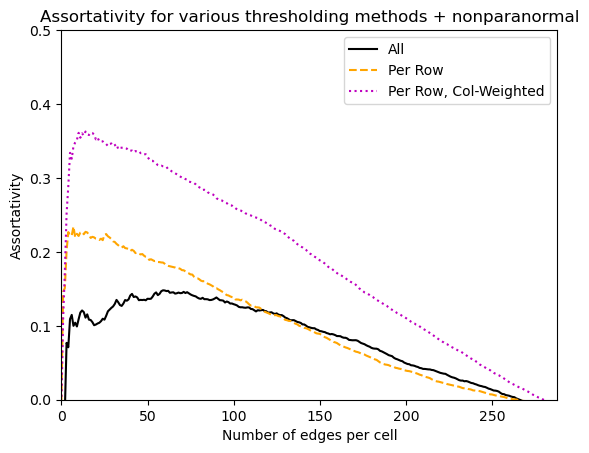

In [30]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(3):
    ax.plot(
        thresholds,
        results[i, :],
        label=f"{threshold_types[i]}"
    )
ax.set_xlabel("Number of edges per cell")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(0, 288)
ax.set_ylim(0, 0.5)

ax.set_title("Assortativity for various thresholding methods + nonparanormal")
fig.savefig("../out_figs/mouse-assortativity-thresholding-nonpara.png")
fig.savefig("../out_figs/mouse-assortativity-thresholding-nonpara.svg")
pass

# Experiment 2: Thresholding Demeaned

In [11]:
log_counts, labels = reload_data(
    shuffle=False,
    divide_by_std=False
)

In [20]:
# Vary threshold, calculate assortativity
thresholds = np.linspace(0, 288, 288).astype(int)
threshold_types = ["All", "Per Row", "Per Row, Col-Weighted"]
preds = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=10_000,
    regularizer=None,
)
results = calculate_assortativities(thresholds, preds)

(0/288): threshold = 0
(28/288): threshold = 28
(56/288): threshold = 56
(84/288): threshold = 84
(112/288): threshold = 112
(140/288): threshold = 140
(168/288): threshold = 168
(196/288): threshold = 196
(224/288): threshold = 224
(252/288): threshold = 252
(280/288): threshold = 280


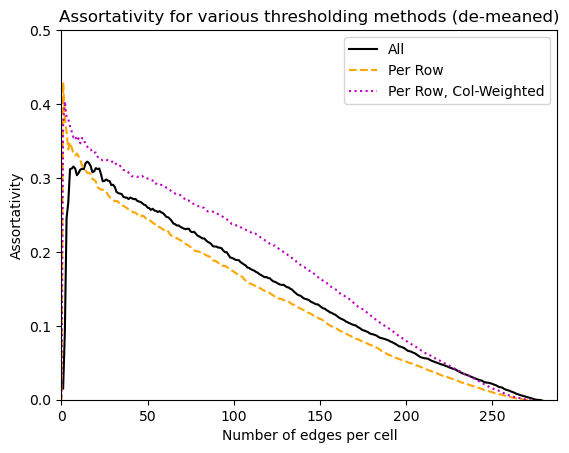

In [21]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(3):
    ax.plot(
        thresholds,
        results[i, :],
        label=f"{threshold_types[i]}"
    )
ax.set_xlabel("Number of edges per cell")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(0, 288)
ax.set_ylim(0, 0.5)

ax.set_title("Assortativity for various thresholding methods (de-meaned)")
fig.savefig("../out_figs/mouse-assortativity-thresholding-demeaned.png")
fig.savefig("../out_figs/mouse-assortativity-thresholding-demeaned.svg")
pass

## Experiment 2b: Thresholding Demeaned Nonparanormal

In [31]:
# Vary threshold, calculate assortativity
thresholds = np.linspace(0, 288, 288).astype(int)
threshold_types = ["All", "Per Row", "Per Row, Col-Weighted"]
nonpara = nonparanormal_tensor_skeptic(log_counts - log_counts.mean())
nonpara = {
    "Cell": nonpara[0],
    "Gene": nonpara[1]
}
preds = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=10_000,
    regularizer=None,
    gram_matrices=nonpara
)
results = calculate_assortativities(thresholds, preds)

(0/288): threshold = 0
(28/288): threshold = 28
(56/288): threshold = 56
(84/288): threshold = 84
(112/288): threshold = 112
(140/288): threshold = 140
(168/288): threshold = 168
(196/288): threshold = 196
(224/288): threshold = 224
(252/288): threshold = 252
(280/288): threshold = 280


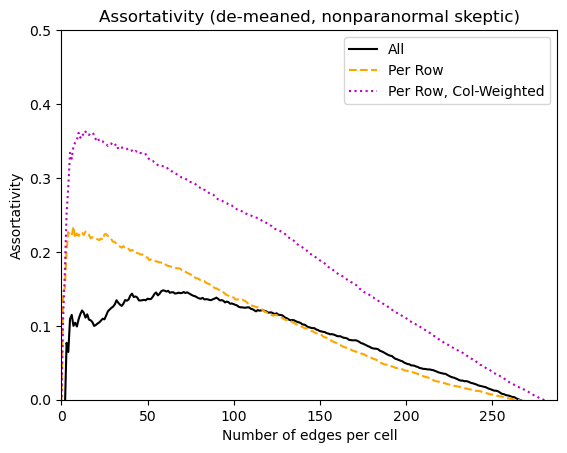

In [32]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(3):
    ax.plot(
        thresholds,
        results[i, :],
        label=f"{threshold_types[i]}"
    )
ax.set_xlabel("Number of edges per cell")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(0, 288)
ax.set_ylim(0, 0.5)

ax.set_title("Assortativity (de-meaned, nonparanormal skeptic)")
fig.savefig("../out_figs/mouse-assortativity-thresholding-demeaned-nonpara.png")
fig.savefig("../out_figs/mouse-assortativity-thresholding-demeaned-nonpara.svg")
pass

# Experiment 3: Regularization

In [135]:
def goodness_per_reg(rhos: np.ndarray, nonparanormal: bool = False) -> np.ndarray:
    results = np.empty((len(rhos), 3))
    for idx, rho in enumerate(rhos):
        if idx % (len(rhos) // 10) == 0:
            print(f"({idx}/{rhos.shape[0]}): rho = {rho}")
        # Get results
        nonpara = None
        if nonparanormal:
            nonpara = nonparanormal_tensor_skeptic(log_counts - log_counts.mean())
            nonpara = {
                "Cell": nonpara[0],
                "Gene": nonpara[1]
            }
        preds = GmGM(
            {"Test Dataset": (log_counts - log_counts.mean())},
            {"Test Dataset": ("Batch", "Cell", "Gene")},
            batch_axes={"Batch"},
            max_iter=1000,
            regularizer=reg.L1({"Cell": rho, "Gene": rho}),
            tol=1e-5,
            _always_regularize=True,
            _check_overstep_each_iter=True,
            gram_matrices=nonpara
        )
        
        # Threshold
        preds = shrink_per_col(
            preds,
            {"Cell": 1, "Gene": 1}
        )


        squished = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                squished[i, j] = abs(preds["Cell"][i*96:(i+1)*96, j*96:(j+1)*96]).sum()

        results[idx, :] = np.diag(squished) / squished.sum(axis=1)
    return results

In [136]:
# Set upper bound to -2 to see zone of chaos, -2.5 to just see good results
rhos = 10**np.linspace(-4, -2, 100)
results = goodness_per_reg(rhos)

(0/100): rho = 0.0001
(10/100): rho = 0.00015922827933410923
(20/100): rho = 0.00025353644939701115
(30/100): rho = 0.0004037017258596554
(40/100): rho = 0.0006428073117284319
(50/100): rho = 0.001023531021899027
(60/100): rho = 0.0016297508346206436
(70/100): rho = 0.002595024211399737
(80/100): rho = 0.0041320124001153384
(90/100): rho = 0.006579332246575682


rho_best G1 = 0.003593813663804626
rho_best S = 0.0037649358067924714
rho_best G2M = 0.004534878508128582
rho_best sum = 0.0037649358067924714


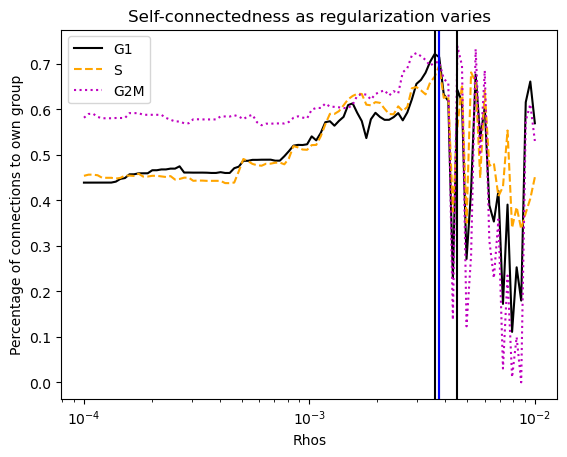

In [137]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(3):
    ax.plot(
        rhos,
        results[:, i],
        label=f"{['G1', 'S', 'G2M'][i]}"
    )
ax.set_xlabel("Rhos")
ax.set_ylabel("Percentage of connections to own group")
ax.legend()

# Log scale
ax.set_xscale("log")

# Place a vertical line when the G1 value is highest
ax.axvline(rhos[np.argmax(results[:, 0])], color="black", linestyle="-")
print(f"rho_best G1 = {rhos[np.argmax(results[:, 0])]}")

# Place a vertical line when the S value is highest
ax.axvline(rhos[np.argmax(results[:, 1])], color="black", linestyle="-")
print(f"rho_best S = {rhos[np.argmax(results[:, 1])]}")

# Place a vertical line when the G2M value is highest
ax.axvline(rhos[np.argmax(results[:, 2])], color="black", linestyle="-")
print(f"rho_best G2M = {rhos[np.argmax(results[:, 2])]}")

# Place a vertical line where their sum is highest
ax.axvline(rhos[np.argmax(results.sum(axis=1))], color="blue", linestyle="-")
print(f"rho_best sum = {rhos[np.argmax(results.sum(axis=1))]}")

ax.set_title("Self-connectedness as regularization varies")

fig.savefig("../out_figs/mouse-self-connectedness-reg.png")
fig.savefig("../out_figs/mouse-self-connectedness-reg.svg")

In [138]:
# Vary threshold, calculate assortativity
thresholds = np.linspace(0, 288, 288).astype(int)
threshold_types = [
    "All", "Per Row", "Per Row, Col-Weighted",
    "All Reg", "Per Row Reg", "Per Row, Col-Weighted, Reg"
]
results = np.empty((6, len(thresholds)))
preds = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=1000,
    regularizer=None,
    _always_regularize=True,
    _check_overstep_each_iter=True
)
preds_reg = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=1000,
    regularizer=reg.L1({"Cell": 0.0037649358067924714, "Gene": 0.0037649358067924714}),
    _always_regularize=True,
    _check_overstep_each_iter=True
)

for idx, threshold in enumerate(thresholds):
    if idx % (len(thresholds) // 10) == 0:
        print(f"({idx}/{thresholds.shape[0]}): threshold = {threshold}")
    # Get results

    # All ############################

    # Threshold
    preds_all = shrink_sparsities(
        preds,
        {"Cell": threshold / 288, "Gene": threshold / 288}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_all["Cell"] + preds_all["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[0, idx] = g.assortativity(labels)

    # All Reg ########################

    # Threshold
    preds_all_reg = shrink_sparsities(
        preds_reg,
        {"Cell": threshold / 288, "Gene": threshold / 288}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_all_reg["Cell"] + preds_all_reg["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[3, idx] = g.assortativity(labels)

    # Per Row #######################

    # Threshold
    preds_row = shrink_per_row(
        preds,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_row["Cell"] + preds_row["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[1, idx] = g.assortativity(labels)

    # Per Row Reg ###################

    # Threshold
    preds_row_reg = shrink_per_row(
        preds_reg,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_row_reg["Cell"] + preds_row_reg["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[4, idx] = g.assortativity(labels)

    # Per Row, Col-Weighted #########
    
    # Threshold
    preds_col = shrink_per_col(
        preds,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_col["Cell"] + preds_col["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[2, idx] = g.assortativity(labels)

    # Per Row, Col-Weighted Reg #####

    # Threshold
    preds_col_reg = shrink_per_col(
        preds_reg,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_col_reg["Cell"] + preds_col_reg["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[5, idx] = g.assortativity(labels)

(0/288): threshold = 0
(28/288): threshold = 28
(56/288): threshold = 56
(84/288): threshold = 84
(112/288): threshold = 112
(140/288): threshold = 140
(168/288): threshold = 168
(196/288): threshold = 196
(224/288): threshold = 224
(252/288): threshold = 252
(280/288): threshold = 280


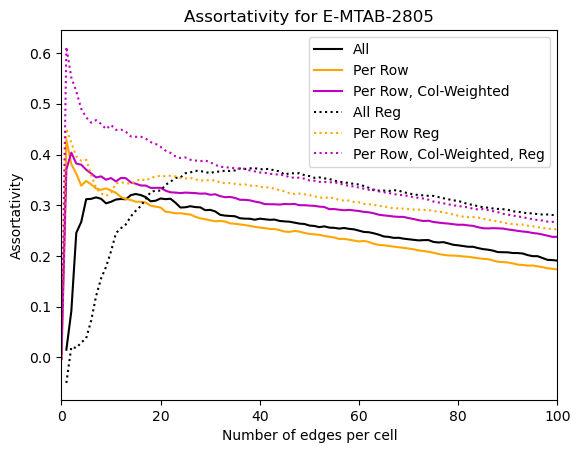

In [139]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(6):
    ax.plot(
        thresholds,
        results[i, :],
        label=f"{threshold_types[i]}",
        linestyle="-" if i < 3 else ":",
        color=['k', 'orange', 'm', 'k', 'orange', 'm'][i]
    )
ax.set_xlabel("Number of edges per cell")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(0, 100)

ax.set_title("Assortativity for E-MTAB-2805")

fig.savefig("../out_figs/mouse-assortativity-reg-compare.png")
fig.savefig("../out_figs/mouse-assortativity-reg-compare.svg")

In [140]:
# Use for later experiment
results_without_nonparanormal = results.copy()

## Experiment 3b: Regularization with Nonparanormal

In [130]:
# Set upper bound to -2 to see zone of chaos, -2.5 to just see good results
rhos = 10**np.linspace(-4, -2, 100)
results = goodness_per_reg(rhos, nonparanormal=True)

(0/100): rho = 0.0001
(10/100): rho = 0.00015922827933410923
(20/100): rho = 0.00025353644939701115
(30/100): rho = 0.0004037017258596554
(40/100): rho = 0.0006428073117284319
(50/100): rho = 0.001023531021899027
(60/100): rho = 0.0016297508346206436
(70/100): rho = 0.002595024211399737
(80/100): rho = 0.0041320124001153384
(90/100): rho = 0.006579332246575682


rho_best G1 = 0.0047508101621027985
rho_best S = 0.0004430621457583882
rho_best G2M = 0.003430469286314919
rho_best sum = 0.0047508101621027985


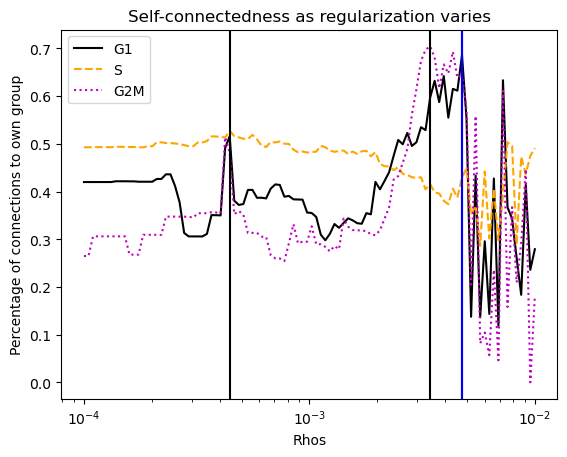

In [131]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(3):
    ax.plot(
        rhos,
        results[:, i],
        label=f"{['G1', 'S', 'G2M'][i]}"
    )
ax.set_xlabel("Rhos")
ax.set_ylabel("Percentage of connections to own group")
ax.legend()

# Log scale
ax.set_xscale("log")

# Place a vertical line when the G1 value is highest
ax.axvline(rhos[np.argmax(results[:, 0])], color="black", linestyle="-")
print(f"rho_best G1 = {rhos[np.argmax(results[:, 0])]}")

# Place a vertical line when the S value is highest
ax.axvline(rhos[np.argmax(results[:, 1])], color="black", linestyle="-")
print(f"rho_best S = {rhos[np.argmax(results[:, 1])]}")

# Place a vertical line when the G2M value is highest
ax.axvline(rhos[np.argmax(results[:, 2])], color="black", linestyle="-")
print(f"rho_best G2M = {rhos[np.argmax(results[:, 2])]}")

# Place a vertical line where their sum is highest
ax.axvline(rhos[np.argmax(results.sum(axis=1))], color="blue", linestyle="-")
print(f"rho_best sum = {rhos[np.argmax(results.sum(axis=1))]}")

ax.set_title("Self-connectedness as regularization varies")

fig.savefig("../out_figs/mouse-self-connectedness-reg-nonpara.png")
fig.savefig("../out_figs/mouse-self-connectedness-reg-nonpara.svg")

In [132]:
# Vary threshold, calculate assortativity
thresholds = np.linspace(0, 288, 288).astype(int)
threshold_types = [
    "All", "Per Row", "Per Row, Col-Weighted",
    "All Reg", "Per Row Reg", "Per Row, Col-Weighted, Reg"
]
results = np.empty((6, len(thresholds)))
nonpara = nonparanormal_tensor_skeptic(log_counts - log_counts.mean())
nonpara = {
    "Cell": nonpara[0],
    "Gene": nonpara[1]
}
preds = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=1000,
    regularizer=None,
    _always_regularize=True,
    _check_overstep_each_iter=True,
    gram_matrices=nonpara
)
preds_reg = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=1000,
    regularizer=reg.L1({"Cell": 0.0047508101621027985, "Gene": 0.0047508101621027985}),
    _always_regularize=True,
    _check_overstep_each_iter=True,
    gram_matrices=nonpara
)

for idx, threshold in enumerate(thresholds):
    if idx % (len(thresholds) // 10) == 0:
        print(f"({idx}/{thresholds.shape[0]}): threshold = {threshold}")
    # Get results

    # All ############################

    # Threshold
    preds_all = shrink_sparsities(
        preds,
        {"Cell": threshold / 288, "Gene": threshold / 288}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_all["Cell"] + preds_all["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[0, idx] = g.assortativity(labels)

    # All Reg ########################

    # Threshold
    preds_all_reg = shrink_sparsities(
        preds_reg,
        {"Cell": threshold / 288, "Gene": threshold / 288}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_all_reg["Cell"] + preds_all_reg["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[3, idx] = g.assortativity(labels)

    # Per Row #######################

    # Threshold
    preds_row = shrink_per_row(
        preds,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_row["Cell"] + preds_row["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[1, idx] = g.assortativity(labels)

    # Per Row Reg ###################

    # Threshold
    preds_row_reg = shrink_per_row(
        preds_reg,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_row_reg["Cell"] + preds_row_reg["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[4, idx] = g.assortativity(labels)

    # Per Row, Col-Weighted #########
    
    # Threshold
    preds_col = shrink_per_col(
        preds,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_col["Cell"] + preds_col["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[2, idx] = g.assortativity(labels)

    # Per Row, Col-Weighted Reg #####

    # Threshold
    preds_col_reg = shrink_per_col(
        preds_reg,
        {"Cell": threshold, "Gene": threshold}
    )

    # Create igraph graph from preds["Cell"]
    g = ig.Graph.Weighted_Adjacency(
        preds_col_reg["Cell"] + preds_col_reg["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    # Calculate assortativity
    results[5, idx] = g.assortativity(labels)

(0/288): threshold = 0
(28/288): threshold = 28
(56/288): threshold = 56
(84/288): threshold = 84
(112/288): threshold = 112
(140/288): threshold = 140
(168/288): threshold = 168
(196/288): threshold = 196
(224/288): threshold = 224
(252/288): threshold = 252
(280/288): threshold = 280


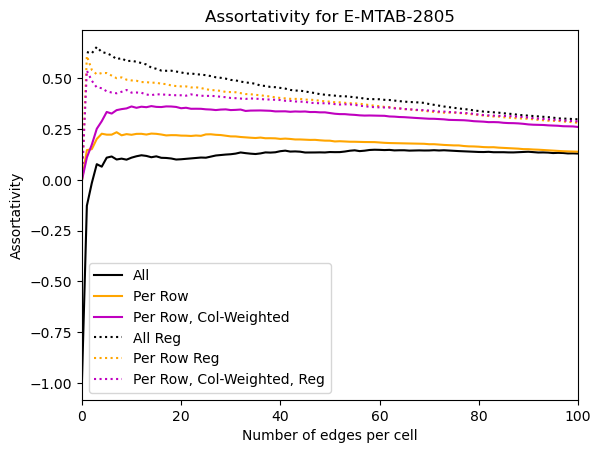

In [133]:
# Plot results
fig, ax = plt.subplots(ncols=1)
for i in range(6):
    ax.plot(
        thresholds,
        results[i, :],
        label=f"{threshold_types[i]}",
        linestyle="-" if i < 3 else ":",
        color=['k', 'orange', 'm', 'k', 'orange', 'm'][i]
    )
ax.set_xlabel("Number of edges per cell")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(0, 100)

ax.set_title("Assortativity for E-MTAB-2805")

fig.savefig("../out_figs/mouse-assortativity-reg-compare-nonpara.png")
fig.savefig("../out_figs/mouse-assortativity-reg-compare-nonpara.svg")

In [134]:
# Use for later experiment
results_with_nonparanormal = results.copy()

# Experiment 4: Compare with EiGLasso

In [119]:
regs = 10**np.linspace(-1.5, 1, 100)
assorts = []
num_edges = []
for reg_ in regs:
    print(f"reg = {reg_}")
    Psis = EiGLasso(log_counts - log_counts.mean(), beta_1=reg_, beta_2=reg_)
    Psis = {
        "Cell": Psis[0],
        "Gene": Psis[1]
    }

    g = ig.Graph.Weighted_Adjacency(
        Psis["Cell"] + Psis["Cell"].T,
        mode="undirected",
        attr="weight",
        loops=False
    )

    num_edges.append(g.ecount() / 288)
    assorts.append(g.assortativity(labels))

reg = 0.03162277660168379
reg = 0.033516026509388425
reg = 0.03552262494616665
reg = 0.037649358067924674
reg = 0.03990341831649379
reg = 0.04229242874389499
reg = 0.044824468792893105
reg = 0.047508101621027955
reg = 0.050352403060530404
reg = 0.0533669923120631
reg = 0.0565620644760902
reg = 0.05994842503189409
reg = 0.06353752638084484
reg = 0.06734150657750822
reg = 0.07137323037957845
reg = 0.07564633275546291
reg = 0.0801752649966579
reg = 0.08497534359086442
reg = 0.09006280202112786
reg = 0.09545484566618337
reg = 0.10116970998767498
reg = 0.10722672220103231
reg = 0.11364636663857249
reg = 0.12045035402587821
reg = 0.12766169490574078
reg = 0.1353047774579807
reg = 0.14340544997832724
reg = 0.15199110829529336
reg = 0.16109078842068333
reg = 0.17073526474706904
reg = 0.1809571541243321
reg = 0.19179102616724883
reg = 0.20327352016717123
reg = 0.2154434690031884
reg = 0.22834203047182716
reg = 0.24201282647943823
reg = 0.2565020905680045
reg = 0.27185882427329405
reg = 0.288134

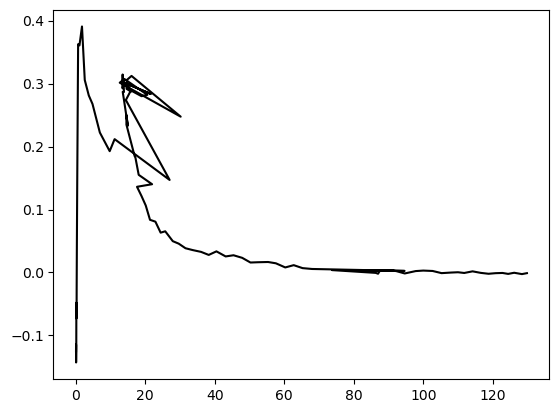

In [120]:
plt.plot(num_edges, assorts)

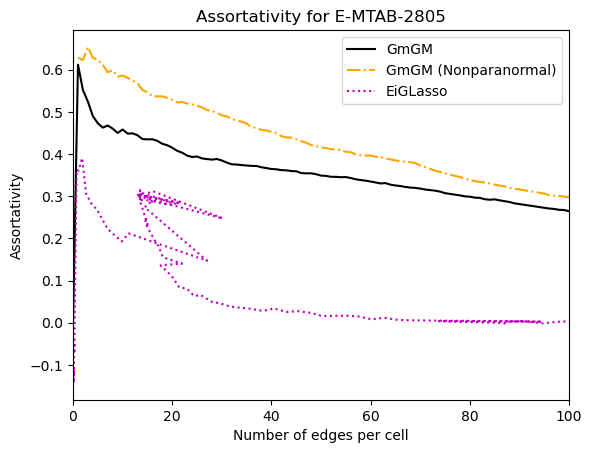

In [141]:
# Plot results
fig, ax = plt.subplots(ncols=1)
ax.plot(
    thresholds,
    results_without_nonparanormal[5, :],
    label=f"GmGM",
    linestyle="-",
    color='k'
)
ax.plot(
    thresholds,
    results_with_nonparanormal[3, :],
    label=f"GmGM (Nonparanormal)",
    linestyle="-.",
    color='orange'
)
ax.plot(
    num_edges,
    assorts,
    label=f"EiGLasso",
    linestyle=":",
    color='m'
)
ax.set_xlabel("Number of edges per cell")
ax.set_ylabel("Assortativity")
ax.legend()
ax.set_xlim(0, 100)

ax.set_title("Assortativity for E-MTAB-2805")

fig.savefig("../out_figs/mouse-assortativity-vs-eiglasso.png")
fig.savefig("../out_figs/mouse-assortativity-vs-eiglasso.svg")

## Experiment 4b: Runtimes

In [92]:
def to_time():
    GmGM(
        {"Test Dataset": (log_counts - log_counts.mean())},
        {"Test Dataset": ("Batch", "Cell", "Gene")},
        batch_axes={"Batch"},
        max_iter=1000,
        regularizer=None,
        _always_regularize=True,
        _check_overstep_each_iter=True,
    )

np.mean(timeit.repeat(
    to_time,
    repeat=10,
    number=1
))

0.00789346250021481

In [91]:
def to_time():
    nonpara = nonparanormal_tensor_skeptic(log_counts - log_counts.mean())
    nonpara = {
        "Cell": nonpara[0],
        "Gene": nonpara[1]
    }
    GmGM(
        {"Test Dataset": (log_counts - log_counts.mean())},
        {"Test Dataset": ("Batch", "Cell", "Gene")},
        batch_axes={"Batch"},
        max_iter=1000,
        regularizer=None,
        _always_regularize=True,
        _check_overstep_each_iter=True,
        gram_matrices=nonpara
    )

np.mean(timeit.repeat(
    to_time,
    repeat=10,
    number=1
))

0.04270532089940389

In [95]:
def to_time():
    EiGLasso(log_counts - log_counts.mean(), beta_1=0, beta_2=0)

np.mean(timeit.repeat(
    to_time,
    repeat=10,
    number=1
))

29.605033133096004

In [94]:
def to_time():
    nonpara = nonparanormal_tensor_skeptic(log_counts - log_counts.mean())
    EiGLasso_cov(nonpara[0], nonpara[1], beta_1=0, beta_2=0)

np.mean(timeit.repeat(
    to_time,
    repeat=10,
    number=1
))

108.48705970410374

# Experiment 5: UMAP Consistency

Not very interesting - UMAP does not separate the cell types!

In [194]:
import scanpy as sc
import igraph as ig

In [150]:
# Create a scanpy object froun counts
adata = sc.AnnData(log_counts[0])

# Add labels
adata.obs["labels"] = labels.astype(int)

# Do UMAP
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

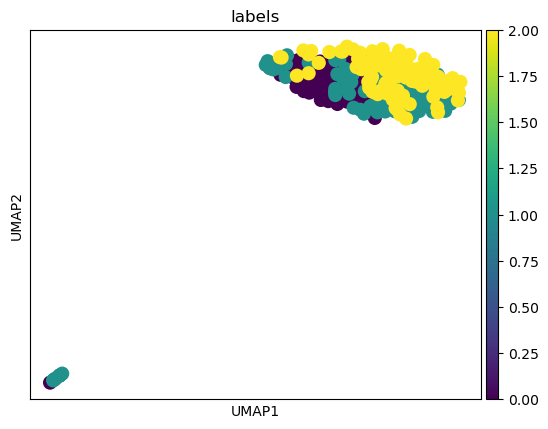

In [151]:
# Plot UMAP colored by label
sc.pl.umap(adata, color="labels")

In [152]:
nonpara = nonparanormal_tensor_skeptic(log_counts - log_counts.mean())
nonpara = {
    "Cell": nonpara[0],
    "Gene": nonpara[1]
}
preds_reg = GmGM(
    {"Test Dataset": (log_counts - log_counts.mean())},
    {"Test Dataset": ("Batch", "Cell", "Gene")},
    batch_axes={"Batch"},
    max_iter=1000,
    regularizer=reg.L1({"Cell": 0.0047508101621027985, "Gene": 0.0047508101621027985}),
    _always_regularize=True,
    _check_overstep_each_iter=True,
    gram_matrices=nonpara
)

In [238]:
# Create Graph
adj_mat = np.abs(shrink_per_col(
    preds_reg,
    {"Cell": 1, "Gene": 1}
)["Cell"])
adj_mat = adj_mat + adj_mat.T
cell_graph = ig.Graph.Adjacency(adj_mat != 0).as_undirected()

# Louvain clustering
cell_graph.vs["labels"] = labels.astype(int)
cell_graph.vs["louvain"] = cell_graph.community_multilevel().membership
adata.obs["louvain"] = cell_graph.vs["louvain"]

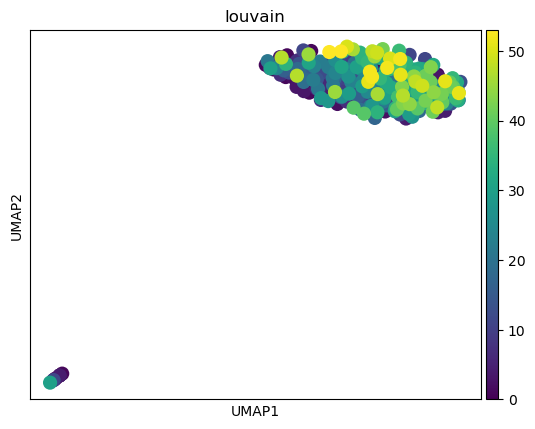

In [239]:
# Plot UMAP colored by label
sc.pl.umap(adata, color="louvain")